In [145]:
from sklearn.datasets import fetch_openml
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split
import torch
import torch.nn as nn
import torch.nn.functional as F
from tqdm import trange
from sklearn.metrics import confusion_matrix
import seaborn as sns

In [85]:
X, y = fetch_openml('mnist_784', version=1, return_X_y=True, as_frame=False)
X = torch.from_numpy(X).float()
y = np.array(y, dtype='int')
y = torch.from_numpy(y)

In [131]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.05)

In [174]:
class NicoNet(nn.Module):
    def __init__(self, in_shape, n_classes):
        super(NicoNet, self).__init__()
        self.fc1 = nn.Linear(in_shape, in_shape)
        self.fc2 = nn.Linear(in_shape, n_classes)
    
    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
       # x = torch.sigmoid(x)
        return x
        

loss: 0.17, acc: 1e+00: 100%|██████████| 1000/1000 [00:06<00:00, 155.31it/s]


The test accuracy is 94.5%.


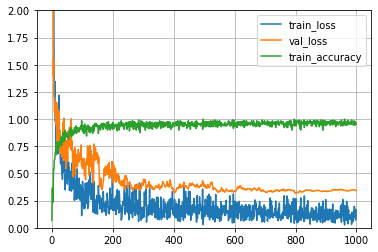

In [189]:
model = NicoNet(X_train.shape[1], 10)
optim = torch.optim.SGD(model.parameters(),lr = 0.007)
loss_function = torch.nn.CrossEntropyLoss()
loss_history = []
val_loss = []
scheduler = torch.optim.lr_scheduler.StepLR(optim, step_size=30, gamma=0.9)
accuracy_history = []
batch_size = 128

for epoch in (t := trange(1000)):
    optim.zero_grad()
    samp = np.random.randint(0, X_train.shape[0], batch_size)
    X_batch = X_train[samp]
    y_batch = y_train[samp]
    y_pred = model(X_batch)
    cat = torch.argmax(y_pred, axis=1)
    accuracy = (cat == y_batch).float().mean()
    loss = loss_function(y_pred, y_batch)
    loss.backward()
    optim.step()
    scheduler.step()
    loss_history.append(loss.detach().numpy())
    accuracy_history.append(accuracy.detach().numpy())
    with torch.no_grad():
        y_test_pred = model(X_test[:20])
        val_loss.append(loss_function(y_test_pred,y_test[:20]).detach().numpy())
    t.set_description(f'loss: {loss.detach().numpy():.2}, acc: {accuracy.detach().numpy():.1}')

     
plt.plot(loss_history)
plt.plot(val_loss)
plt.plot(accuracy_history)
plt.grid()
plt.ylim([0,2])
plt.legend(['train_loss', 'val_loss', 'train_accuracy'])
y_test_pred = torch.argmax(model(X_test), axis=1)
test_acc = (y_test_pred == y_test).float().mean()
print(f'The test accuracy is {test_acc:.1%}.')

In [190]:
confusion_matrix(y_test, y_test_pred)

array([[347,   0,   1,   0,   1,   0,   2,   0,   6,   2],
       [  1, 391,   0,   1,   0,   1,   0,   1,   3,   0],
       [  1,   2, 323,   4,   1,   0,   1,   2,   3,   0],
       [  0,   2,   7, 313,   1,   3,   0,   3,   8,   2],
       [  0,   0,   2,   1, 319,   0,   2,   4,   6,   6],
       [  1,   0,   1,   6,   1, 298,   6,   1,   5,   8],
       [  2,   0,   1,   0,   3,   4, 336,   0,   2,   0],
       [  1,   4,   5,   4,   5,   1,   0, 347,   1,   6],
       [  1,   1,   5,   9,   0,   4,   1,   0, 313,   5],
       [  2,   0,   1,   3,   6,   1,   3,   2,   2, 319]])

<AxesSubplot:>

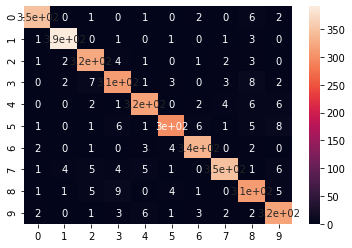

In [191]:
cf_matrix = confusion_matrix(y_test, y_test_pred)
sns.heatmap(cf_matrix, annot=True)